In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [3]:
# Load Data
data = pd.read_csv("first_trend_df_1117.csv")
data.shape

(6250, 63)

In [5]:
X = data
X = X.drop(['Unnamed: 0', 'video_id', 'trending_date', 'channel_title','category_id','thumbnail_link','publish_date','app_time','tags2','category'], axis = 1)
y = data['app_time'] <= 1 ### 1 for only trending once within 31 days, 0 otherwise

In [8]:
# Cross Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

params = {'n_estimators': [50, 100, 200], 'min_child_weight': [3, 4, 5],
         'max_depth':[5, 6, 7], 'gamma': [(0.5*i) for i in range(5)]}

gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, subsample=0.8, colsample_bytree=0.8, 
                                                 early_stopping_round=100, objective= 'binary:logistic', 
                                                nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = params, scoring='roc_auc',n_jobs=1,iid=False, cv=5)
gsearch.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, early_stopping_round=100, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200], 'min_child_weight': [3, 4, 5], 'max_depth': [5, 6, 7], 'gamma': [0.0, 0.5, 1.0, 1.5, 2.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [9]:
# Best Parameter
print(gsearch.best_score_)
print(gsearch.best_params_)

0.7600195096909141
{'gamma': 1.0, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 50}


In [10]:
# Refit
xgb = XGBClassifier(learning_rate =0.1, n_estimators=50, max_subsample=0.8, colsample_bytree=0.8,
                                                 max_depth=6, min_child_weight=4, early_stopping_round=50,
                     objective= 'binary:logistic', gamma=1, nthread=4, scale_pos_weight=1, seed=27)

In [11]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, early_stopping_round=50, gamma=1,
       learning_rate=0.1, max_delta_step=0, max_depth=6, max_subsample=0.8,
       min_child_weight=4, missing=None, n_estimators=50, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True, subsample=1)

In [12]:
# Prediction & Performance
y_pred = xgb.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

recall = tp / (tp + fn)
precision = tp / (tp + fp)
fp_rate = fp / (fp + tn)
f1_score = 2 * (precision * recall / (precision + recall))
accuracy = (tp + tn) / (tp + tn + fp + fn)
print("recall:", recall, "\n precision:", precision, "\n fp_rate:",fp_rate, "\n f1_score:",f1_score, "\n accuracy:",accuracy)

recall: 0.022388059701492536 
 precision: 0.2727272727272727 
 fp_rate: 0.007168458781362007 
 f1_score: 0.04137931034482758 
 accuracy: 0.8888


/Users/yuexuanhuang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


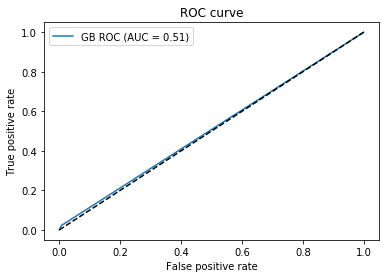

In [15]:
fpr_clf, tpr_clf, _ = roc_curve(y_test, y_pred)
xb_auc = auc(fpr_clf, tpr_clf)

plt.figure(1)
plt.plot(fpr_clf, tpr_clf, 
         label=r'GB ROC (AUC = %0.2f)' % (xb_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()